 # Question 3
 Train a YOLOv3 model on the dataset mentioned above for object localization and evaluate its performance. Provide model output from data point used in Question 2. <br>
 [Note: Marks will be given based on different experiments and discussion]








In [1]:
# %%

import torch
import numpy as np
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from matplotlib import pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [2]:
# %%

import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    """
    Convolutional Block: Conv -> BatchNorm -> LeakyReLU
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        return self.leaky(self.bn(self.conv(x)))

In [3]:
# %%

class ResidualBlock(nn.Module):
    """
    Residual Block: (Conv -> Conv) + Skip Connection
    """
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        # First 1x1 convolution to reduce channels
        self.conv1 = ConvBlock(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        # Then 3x3 convolution to restore channels
        self.conv2 = ConvBlock(out_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        return out + residual

In [4]:
# %%

class Upsample(nn.Module):
    def __init__(self, scale_factor=2, mode = 'nearest'):
        super(Upsample, self).__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode = mode)

    def forward(self, x):
        return self.upsample(x)

In [5]:
# %%

class Darknet53(nn.Module):
    def __init__(self):
        super(Darknet53,  self).__init__()
        self.layers = self.__create_layers__()

    def __create_layers__(self):
        layers = []
        in_chan = 3
        layers.append(ConvBlock(in_chan, 32, 3, 1, 1))

        in_chan = 32

        res_blocks = [1,2,8,8,4]

        conv_blocks_filters = [64, 128, 256, 512, 1024]

        self.pause = []
        for i, chn_sz in enumerate(conv_blocks_filters):
            layers.append(ConvBlock(in_chan, chn_sz, 3, 2, 1))
            in_chan = chn_sz
            for b in range(res_blocks[i]):
                layers.append(ResidualBlock(in_chan, in_chan//2))

            if i == 2 or i==3 or i==4:
                self.pause.append(len(layers)-1)



        return nn.Sequential(*layers)

    def forward(self,x):
        outputs = []
        for layer_num, layer in enumerate(self.layers):
            x = layer(x)
            if layer_num in self.pause:
                outputs.append(x)
        return outputs

In [6]:
# %%

class DetectorHead(nn.Module):

    def __init__(self, in_channels, out_channels, num_classes):
        super(DetectorHead, self).__init__()
        self.layers = nn.Sequential(
            ConvBlock(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            ConvBlock(out_channels, in_channels * 2, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels * 2, out_channels, kernel_size=1, stride=1, padding=0),
            ConvBlock(out_channels, in_channels * 2, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels * 2, out_channels, kernel_size=1, stride=1, padding=0),
            ConvBlock(out_channels, in_channels * 2, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels * 2, out_channels, kernel_size=1, stride=1, padding=0),
            # Final convolution for predictions
            nn.Conv2d(out_channels, 3 * (5 + num_classes), kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        return self.layers(x)

In [7]:
# %%

class YOLOv3(nn.Module):
    def __init__(self, num_classes=80):
        super(YOLOv3, self).__init__()
        self.num_classes = num_classes

        # Backbone
        self.backbone = Darknet53()

        # Detection Heads
        # For different scales: 13x13, 26x26, 52x52
        self.head_13 = DetectorHead(in_channels=  1024, out_channels=512, num_classes=num_classes)
        self.head_26 = DetectorHead(in_channels=  768, out_channels=256, num_classes=num_classes)
        self.head_52 = DetectorHead(in_channels=  384, out_channels=128, num_classes=num_classes)

        # Additional layers for upsampling and concatenation
        self.upsample = Upsample()
        self.conv_set_26 = nn.Sequential(
            ConvBlock(1024, 256, kernel_size=1, stride=1, padding=0),
            ConvBlock(256, 512, kernel_size=3, stride=1, padding=1),
            ConvBlock(512, 256, kernel_size=1, stride=1, padding=0),
            ConvBlock(256, 512, kernel_size=3, stride=1, padding=1),
            ConvBlock(512, 256, kernel_size=1, stride=1, padding=0)
        )

        self.conv_set_52 = nn.Sequential(
            ConvBlock( 768, 128, kernel_size=1, stride=1, padding=0),
            ConvBlock( 128, 256, kernel_size=3, stride=1, padding=1),
            ConvBlock( 256, 128, kernel_size=1, stride=1, padding=0),
            ConvBlock( 128, 256, kernel_size=3, stride=1, padding=1),
            ConvBlock( 256, 128, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        # Backbone
        features = self.backbone(x)  # [52x52, 26x26, 13x13]
        feat_52, feat_26, feat_13 = features

        # Detection Head at 13x13
        out_13 = self.head_13(feat_13)

        # Processing for 26x26
        feat_26_processed = self.conv_set_26(feat_13)
        upsampled_26 = self.upsample(feat_26_processed)
        # Concatenate with feat_26 from backbone
        concat_26 = torch.cat([upsampled_26, feat_26], dim=1)
        # Detection Head at 26x26
        out_26 = self.head_26(concat_26)

        # Processing for 52x52
        feat_52_processed = self.conv_set_52(concat_26)
        upsampled_52 = self.upsample(feat_52_processed)

        # Concatenate with feat_52 from backbone
        concat_52 = torch.cat([upsampled_52, feat_52], dim=1)
        # Detection Head at 52x52
        out_52 = self.head_52(concat_52)

        return out_52, out_26, out_13

In [8]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import cv2, random
import numpy as np
from PIL import Image, ImageFile

class YOLODataset(Dataset):
    def __init__(self, dataset_dir, anchors, target_size=(416, 416), transform=None, split=0):
        """
        Args:
            dataset_dir (str): Path to the dataset directory containing 'faces.csv' and 'images/'.
            anchors (list of lists): Anchors for different scales, e.g., [[...], [...], [...]].
            target_size (tuple): Desired output size of the images (width, height).
            transform (callable, optional): Optional transform to be applied on a sample.
            split (int): 0 for train, 1 for validation, 2 for test.
        """
        self.anchors = anchors
        self.annotations = pd.read_csv(os.path.join(dataset_dir, 'faces.csv'))
        self.img_dir = os.path.join(dataset_dir, 'images')
        self.unique_images = list(self.annotations['image_name'].unique())

        # Shuffle the images to ensure randomness
        random.shuffle(self.unique_images)

        # Split the data into train, validate, and test sets
        n = len(self.unique_images)
        split_60 = int(n * 0.6)  # 60% for training
        split_20 = int(n * 0.2)  # 20% for testing, 20% for validation

        # Split the list
        train = self.unique_images[:split_60]
        test = self.unique_images[split_60:split_60 + split_20]
        validation = self.unique_images[split_60 + split_20:]

        if split == 0:
            self.req_img = train
        elif split == 1:
            self.req_img = validation
        elif split == 2:
            self.req_img = test
        else:
            raise ValueError("Invalid split value. Use 0 for train, 1 for validation, or 2 for test.")

        self.target_size = target_size
        self.transform = transform
        self.iou_thresh = 0.5

    def __len__(self):
        return len(self.req_img)

    def compute_iou(self, box1, box2):
        """
        Compute Intersection over Union (IoU) between two boxes.
        Boxes are in (x_center, y_center, width, height) format.
        """
        x1_min = box1[0] - box1[2] / 2
        y1_min = box1[1] - box1[3] / 2
        x1_max = box1[0] + box1[2] / 2
        y1_max = box1[1] + box1[3] / 2

        x2_min = box2[0] - box2[2] / 2
        y2_min = box2[1] - box2[3] / 2
        x2_max = box2[0] + box2[2] / 2
        y2_max = box2[1] + box2[3] / 2

        inter_x_min = max(x1_min, x2_min)
        inter_y_min = max(y1_min, y2_min)
        inter_x_max = min(x1_max, x2_max)
        inter_y_max = min(y1_max, y2_max)

        inter_area = max(inter_x_max - inter_x_min, 0) * max(inter_y_max - inter_y_min, 0)
        area1 = (x1_max - x1_min) * (y1_max - y1_min)
        area2 = (x2_max - x2_min) * (y2_max - y2_min)
        union_area = area1 + area2 - inter_area

        if union_area == 0:
            return 0
        return inter_area / union_area

    def create_bounding_box_maps(self, boxes, grid_size, img_size, scale_anchors):
        """
        Create bounding box maps for a specific grid size.

        Args:
            boxes (np.array): Array of bounding boxes in (x0, y0, x1, y1) format.
            grid_size (int): The size of the grid (e.g., 52, 26, 13).
            img_size (tuple): Size of the image (width, height).
            scale_anchors (list): Anchors for this scale.

        Returns:
            torch.Tensor: Target tensor of shape (num_anchors * 6, grid_size, grid_size).
        """
        S = grid_size
        num_anchors = len(scale_anchors)
        box_map = torch.zeros((num_anchors * 6, S, S))  # 6 channels per anchor: presence, x0, y0, x1, y1, objectness/confidence

        cell_width = img_size[0] / S
        cell_height = img_size[1] / S

        for box in boxes:
            x0, y0, x1, y1 = box
            x_center = (x0 + x1) / 2
            y_center = (y0 + y1) / 2
            width = x1 - x0
            height = y1 - y0

            # Find the cell where the center falls
            i = int(x_center // cell_width)
            j = int(y_center // cell_height)

            for k, anchor in enumerate(scale_anchors):
                anchor_width = anchor[0]
                anchor_height = anchor[1]

                # Anchor box
                anchor_box = torch.tensor([0, 0, anchor_width, anchor_height])

                # True box
                true_box = torch.tensor([0, 0, width, height])

                # Compute IoU
                iou = self.compute_iou(anchor_box, true_box)

                # Populate the box map
                if iou > self.iou_thresh:
                    box_map[k * 6, j, i] = 1
                    box_map[k * 6 + 1, j, i] = x_center / cell_width - i
                    box_map[k * 6 + 2, j, i] = y_center / cell_height - j
                    box_map[k * 6 + 3, j, i] = width / img_size[0] 
                    box_map[k * 6 + 4, j, i] = height / img_size[1]
                    box_map[k * 6 + 5, j, i] = 1

        return box_map

    def resize_image_and_bbox(self, image, bbox):
        """
        Resize image and adjust bounding box according to the new image size.

        Args:
            image (np.array): Original image.
            bbox (np.array): Bounding boxes in (width, height, x0, y0, x1, y1) format.

        Returns:
            torch.Tensor: Resized image tensor.
            np.array: Adjusted bounding boxes in (x0, y0, x1, y1) format.
        """
        original_height, original_width = image.shape[:2]
        resized_image = cv2.resize(image, self.target_size)
        # Reshape to (channel, height, width)
        resized_image = np.transpose(resized_image, (2, 0, 1))
        scale_x = self.target_size[0] / original_width
        scale_y = self.target_size[1] / original_height

        resized_image = torch.tensor(resized_image, dtype=torch.float32)
        bboxes = []
        for bboxr in bbox:
            _, _, x0, y0, x1, y1 = bboxr

            x0 = x0 * scale_x
            y0 = y0 * scale_y
            x1 = x1 * scale_x
            y1 = y1 * scale_y
            bboxes.append([x0, y0, x1, y1])
        return resized_image, np.array(bboxes)

    def __getitem__(self, idx):
        img_name = self.req_img[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = np.array(Image.open(img_path).convert("RGB"))
        bbox = self.annotations[self.annotations['image_name'] == img_name][['width', 'height', 'x0', 'y0', 'x1', 'y1']].values
        img, bbox = self.resize_image_and_bbox(image, bbox)

        # Generate bounding box maps for each scale
        box_52 = self.create_bounding_box_maps(
            boxes=bbox,
            grid_size=52,
            img_size=self.target_size,
            scale_anchors=self.anchors[0]
        )
        box_26 = self.create_bounding_box_maps(
            boxes=bbox,
            grid_size=26,
            img_size=self.target_size,
            scale_anchors=self.anchors[1]
        )
        box_13 = self.create_bounding_box_maps(
            boxes=bbox,
            grid_size=13,
            img_size=self.target_size,
            scale_anchors=self.anchors[2]
        )

        if self.transform:
            img = self.transform(img)

        return img, [box_52, box_26, box_13]


In [9]:
anchors = [
    [(10,13), (16,30), (33,23)],  # Scale 1 (52x52)
    [(30,61), (62,45), (59,119)], # Scale 2 (26x26)
    [(116,90), (156,198), (373,326)] # Scale 3 (13x13)
]

In [10]:
train = YOLODataset(dataset_dir='yolo_p3', anchors=anchors , split=0)

In [11]:
train.__getitem__(0)[1][0].shape

torch.Size([18, 52, 52])

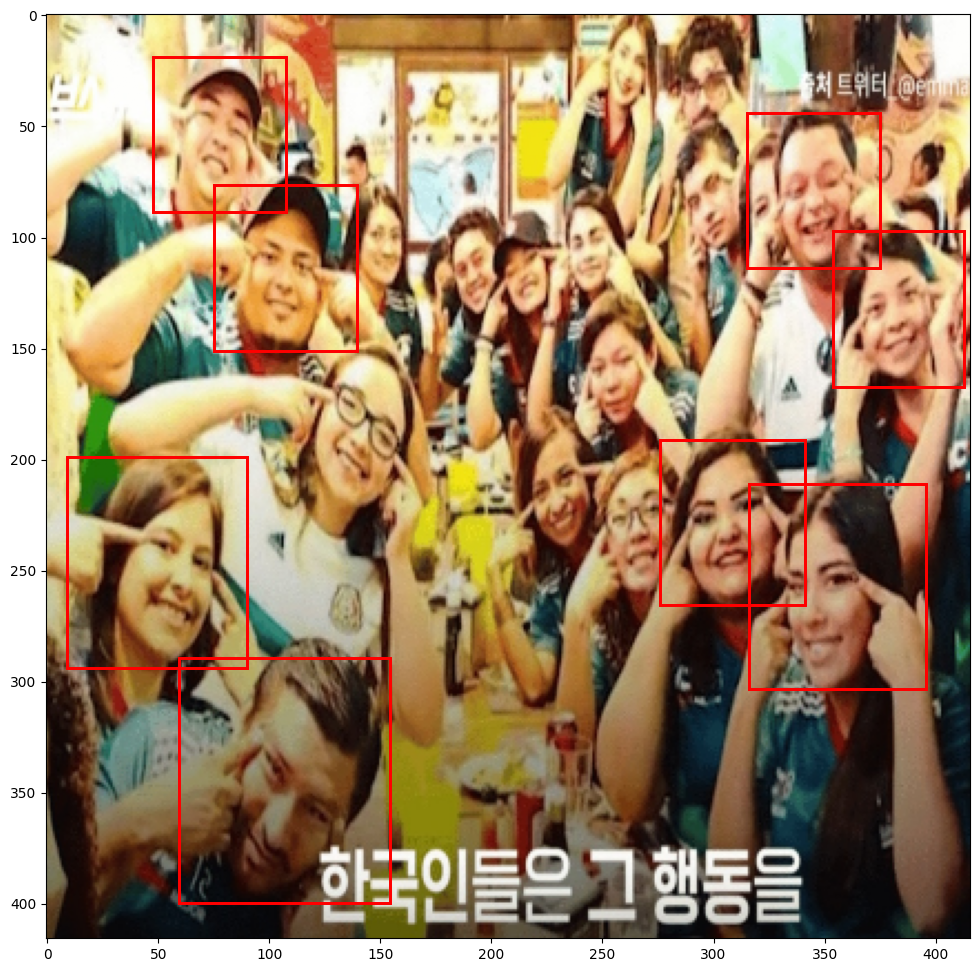

In [12]:
import matplotlib.pyplot as plt
import torch

def visualize_sample(img, box_maps, anchors, grid_sizes):
    """
    Visualize bounding boxes on the image based on the box maps.

    Args:
        img (torch.Tensor): Image tensor of shape (C, H, W).
        box_maps (list of torch.Tensor): List containing box maps for each scale.
        anchors (list of list of tuples): Anchors for each scale.
        grid_sizes (list of int): Grid sizes corresponding to each scale.
    """
    img = img.numpy().transpose(1, 2, 0) / 255.0  # Convert to HWC and normalize
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    ax = plt.gca()

    for scale_idx, box_map in enumerate(box_maps):
        S = grid_sizes[scale_idx]
        scale_anchors = anchors[scale_idx]
        cell_width = img.shape[1] / S
        cell_height = img.shape[0] / S

        num_anchors = len(scale_anchors)
        for anchor_idx in range(num_anchors):
            for i in range(S):
                for j in range(S):
                    box_map = box_map.squeeze()
                    presence = box_map[anchor_idx * 6, i, j].item()
                    if presence > 0:
                        # Retrieve bounding box parameters
                        x_offset = box_map[anchor_idx * 6 + 1, i, j].item()
                        y_offset = box_map[anchor_idx * 6 + 2, i, j].item()
                        width = box_map[anchor_idx * 6 + 3, i, j].item()
                        height = box_map[anchor_idx * 6 + 4, i, j].item()

                        # Calculate the absolute coordinates
                        x_center = (j + x_offset) * cell_width
                        y_center = (i + y_offset) * cell_height
                        abs_width = width * img.shape[1]
                        abs_height = height * img.shape[0]

                        # Calculate top-left corner
                        x0 = x_center - abs_width / 2
                        y0 = y_center - abs_height / 2

                        # Draw rectangle
                        rect = plt.Rectangle(
                            (x0, y0),
                            abs_width,
                            abs_height,
                            fill=False,
                            color='red',
                            linewidth=2
                        )
                        ax.add_patch(rect)

    plt.axis('on')
    plt.show()


train_loader = DataLoader(train, batch_size=1, shuffle=True, num_workers=4)

# Define anchors and grid sizes
anchors = [
    [(10, 13), (16, 30), (33, 23)],         # Scale 1 (52x52)
    [(30, 61), (62, 45), (59, 119)],        # Scale 2 (26x26)
    [(116, 90), (156, 198), (373, 326)]     # Scale 3 (13x13)
]
grid_sizes = [52, 26, 13]

# Example usage with DataLoader
for img, box_maps in train_loader:
    visualize_sample(img[0], box_maps, anchors, grid_sizes)
    break  # Visualize only the first batch



In [13]:
import torch
import torch.nn as nn

class YOLOLoss(nn.Module):
    def __init__(self, anchors, grid_sizes, num_classes=1, device='cuda'):
        """
        Initializes the YOLO Loss function.

        Args:
            anchors (list of list of tuples): Anchors for each scale.
            grid_sizes (list of int): Grid sizes corresponding to each scale.
            num_classes (int): Number of object classes.
            device (str): Device to perform computations on.
        """
        super(YOLOLoss, self).__init__()
        self.anchors = anchors
        self.grid_sizes = grid_sizes
        self.num_classes = num_classes
        self.device = device

        # Define loss functions
        self.mse_loss = nn.MSELoss(reduction='sum')
        self.bce_loss = nn.BCELoss(reduction='sum')  # For objectness
        self.ce_loss = nn.CrossEntropyLoss(reduction='sum')  # For classification

        # Define hyperparameters for loss weighting
        self.lambda_coord = 5  # Weight for localization loss
        self.lambda_noobj = 0.5  # Weight for no object confidence loss

    def compute_iou(self, box1, box2):
        """
        Compute Intersection over Union (IoU) between two boxes.
        Boxes are in (x_center, y_center, width, height) format.
        """
        x1_min = box1[0] - box1[2] / 2
        y1_min = box1[1] - box1[3] / 2
        x1_max = box1[0] + box1[2] / 2
        y1_max = box1[1] + box1[3] / 2

        x2_min = box2[0] - box2[2] / 2
        y2_min = box2[1] - box2[3] / 2
        x2_max = box2[0] + box2[2] / 2
        y2_max = box2[1] + box2[3] / 2

        inter_x_min = max(x1_min, x2_min)
        inter_y_min = max(y1_min, y2_min)
        inter_x_max = min(x1_max, x2_max)
        inter_y_max = min(y1_max, y2_max)

        inter_area = max(inter_x_max - inter_x_min, 0) * max(inter_y_max - inter_y_min, 0)
        area1 = (x1_max - x1_min) * (y1_max - y1_min)
        area2 = (x2_max - x2_min) * (y2_max - y2_min)
        union_area = area1 + area2 - inter_area

        if union_area == 0:
            return 0
        return inter_area / union_area
        
    def forward(self, predictions, targets):
        """
        Computes the YOLO loss.

        Args:
            predictions (list of torch.Tensor): List containing model predictions for each scale.
                Each tensor has shape (batch_size, num_anchors*6, grid_size, grid_size).
            targets (list of torch.Tensor): List containing target tensors for each scale.
                Each tensor has shape (batch_size, num_anchors*6, grid_size, grid_size).

        Returns:
            torch.Tensor: Total loss.
        """

        # if presence > 0:
        #                 # Retrieve bounding box parameters
        #                 x_offset = box_map[anchor_idx * 6 + 1, i, j].item()
        #                 y_offset = box_map[anchor_idx * 6 + 2, i, j].item()
        #                 width = box_map[anchor_idx * 6 + 3, i, j].item()
        #                 height = box_map[anchor_idx * 6 + 4, i, j].item()

        #                 # Calculate the absolute coordinates
        #                 x_center = (j + x_offset) * cell_width
        #                 y_center = (i + y_offset) * cell_height
        #                 abs_width = width * img.shape[1]
        #                 abs_height = height * img.shape[0]

        #                 # Calculate top-left corner
        #                 x0 = x_center - abs_width / 2
        #                 y0 = y_center - abs_height / 2
        
        total_loss = 0

        for scale_idx, (pred, target) in enumerate(zip(predictions, targets)):
            S = self.grid_sizes[scale_idx]
            num_anchors = len(self.anchors[scale_idx])

            # Reshape predictions and targets to (batch_size, num_anchors, 6, S, S)
            pred = pred.view(pred.size(0), num_anchors, 6, S, S)
            target = target.view(target.size(0), num_anchors, 6, S, S)

            obj = target[:, :, 5, :, :] == 1 # Objectness mask
            no_obj = target[:, :, 5, :, :] == 0 # No object mask

            # Objectness score
            pred_conf = nn.functional.sigmoid(pred[:, :, 5, :, :])  # Objectness prediction
            
            obj_loss = self.bce_loss(pred_conf[obj], target[:, :, 5, :, :][obj])
            no_obj_loss = self.lambda_noobj*self.bce_loss(pred_conf[no_obj], target[:, :, 5, :, :][no_obj])

            # Classification loss
            pred_cls = nn.functional.sigmoid(pred[:, :, 0, :, :])  # Class prediction
            target_cls = target[:, :, 0, :, :]
            cls_loss = self.bce_loss(pred_cls[obj], target_cls[obj])

            mask = target[:, :, 5, :, :] == 1
            expanded_mask = mask.unsqueeze(2).expand(-1, -1, 4, -1, -1)
            
            # Localization loss
            loc_pred = pred[:, :, 1:5, :, :]
            loc_target = target[:, :, 1:5, :, :]
            
            loc_loss = self.mse_loss(loc_pred[expanded_mask], loc_target[expanded_mask])


            total_loss += obj_loss + no_obj_loss + cls_loss + loc_loss
            
            

        return total_loss


In [14]:
# %%

import numpy as np

In [17]:
# %%

device = "cuda"
model = YOLOv3(num_classes=1)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = YOLOLoss(anchors, grid_sizes)  # Your custom loss function

# Create DataLoader
dataloader = DataLoader(train, batch_size=16, shuffle=True, num_workers=4)

In [19]:
# %%

import torch
import torch.optim as optim
from tqdm import tqdm

# Assume these are already defined:
# - YOLOv3: Your YOLO model class
# - YOLOLoss: The loss function class
# - dataset: Your custom dataset
# - DataLoader: To load batches of data

# Set up model, optimizer, and loss function

# Training loop
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0

    for batch_idx, (images, targets) in enumerate(dataloader):
        images = images.to(device)  # Shape: (batch_size, 3, H, W)
        # Targets is a list of [box_52, box_26, box_13], each of shape (batch_size, anchors*6, S, S)
        targets = [t.to(device) for t in targets]

        optimizer.zero_grad()
        outputs = model(images)  # Should return a list of predictions per scale

        # Ensure outputs are in the same format as targets
        # Each output should have shape (batch_size, anchors*6, S, S)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    average_epoch_loss = total_epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {average_epoch_loss:.4f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 86.00 MiB. GPU 0 has a total capacity of 3.63 GiB of which 54.19 MiB is free. Including non-PyTorch memory, this process has 3.57 GiB memory in use. Of the allocated memory 3.30 GiB is allocated by PyTorch, and 204.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)